In [14]:
import numpy
from matplotlib import pyplot
from helper import laplace_solution, l2_norm, plot_3d

In [15]:
# Set parameters.
nx = 128
ny = 128
Lx = 5.0
Ly = 5.0
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)

# Create the gridline locations.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Set the initial conditions.
p0 = numpy.zeros((ny, nx))
p0[-1, :] = numpy.sin(1.5 * numpy.pi * x / Lx)

In [17]:
def laplace_2d_jacobi(p0, maxiter=20000, rtol=1e-6):
    p = p0.copy()
    diff = rtol + 1.0
    ite = 0
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        # Update the solution at interior points.
        p[1:-1, 1:-1] = 0.25 * (pn[1:-1, :-2] + pn[1:-1, 2:] +
                                pn[:-2, 1:-1] + pn[2:, 1:-1])
        # Apply 2nd-order Neumann condition (zero-gradient) at the right boundary.
        p[1:-1, -1] = 0.25 * (2.0 * pn[1:-1, -2] +
                              pn[2:, -1] + pn[:-2, -1])
        # Compute the relative L2-norm of the difference.
        diff = l2_norm(p, pn)
        ite += 1
    return p, ite, diff

In [18]:
# Compute the solution using Jacobi relaxation method.
p, ites, diff = laplace_2d_jacobi(p0, maxiter=20000, rtol=1e-8)
print('Jacobi relaxation: {} iterations '.format(ites) +
      'to reach a relative difference of {}'.format(diff))

Jacobi relaxation: 19993 iterations to reach a relative difference of 9.998616841158966e-09


In [19]:
%%timeit
laplace_2d_jacobi(p0, maxiter=20000, rtol=1e-8)

2.71 s ± 24.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
p_exact = laplace_solution(x, y, Lx, Ly)

l2_norm(p, p_exact)

6.173551335297434e-05

In [22]:
def laplace_2d_gauss_seidel(p0, maxiter=20000, rtol=1e-6):
    ny, nx = p0.shape
    p = p0.copy()
    diff = rtol + 1.0  # initial difference
    ite = 0  # iteration index
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        # Update the solution at interior points.
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                p[j, i] = 0.25 * (p[j, i - 1] + p[j, i + 1] +
                                  p[j - 1, i] + p[j + 1, i])
        # Apply 2nd-order Neumann condition (zero-gradient)
        # at the right boundary.
        for j in range(1, ny - 1):
            p[j, -1] = 0.25 * (2.0 * p[j, -2] +
                               p[j - 1, -1] + p[j + 1, -1])
        # Compute the relative L2-norm of the difference.
        diff = l2_norm(p, pn)
        ite += 1
    return p, ite, diff

In [23]:
import numba
from numba import jit

In [24]:
def fib_it(n):
    a, b = 1, 1
    for i in range(n - 2):
        a, b = b, a + b
    return b

In [25]:
%%timeit
fib_it(500000)

2.29 s ± 9.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
@jit
def fib_it(n):
    a, b = 1, 1
    for i in range(n - 2):
        a, b = b, a + b
    return b

In [28]:
%%timeit
fib_it(500000)

291 µs ± 5.78 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [29]:
@jit(nopython=True)
def laplace_2d_jacobi(p0, maxiter=20000, rtol=1e-6):
    ny, nx = p0.shape
    p = p0.copy()
    conv = []  # convergence history
    diff = rtol + 1.0  # initial difference
    ite = 0  # iteration index
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        # Update the solution at interior points.
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                p[j, i] = 0.25 * (pn[j, i - 1] + pn[j, i + 1] +
                                  pn[j - 1, i] + pn[j + 1, i])
        # Apply 2nd-order Neumann condition (zero-gradient)
        # at the right boundary.
        for j in range(1, ny - 1):
            p[j, -1] = 0.25 * (2.0 * pn[j, -2] +
                               pn[j - 1, -1] + pn[j + 1, -1])
        # Compute the relative L2-norm of the difference.
        diff = numpy.sqrt(numpy.sum((p - pn)**2) / numpy.sum(pn**2))
        conv.append(diff)
        ite += 1
    return p, ite, conv

In [30]:
p, ites, conv_jacobi = laplace_2d_jacobi(p0,
                                         maxiter=20000, rtol=1e-8)
print('Jacobi relaxation: {} iterations '.format(ites) +
      'to reach a relative difference of {}'.format(conv_jacobi[-1]))

Jacobi relaxation: 19993 iterations to reach a relative difference of 9.998616841313522e-09


In [31]:
%%timeit
laplace_2d_jacobi(p0, maxiter=20000, rtol=1e-8)

1.61 s ± 8.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
@jit(nopython=True)
def laplace_2d_gauss_seidel(p0, maxiter=20000, rtol=1e-6):
    ny, nx = p0.shape
    p = p0.copy()
    conv = []  # convergence history
    diff = rtol + 1.0  # initial difference
    ite = 0  # iteration index
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        # Update the solution at interior points.
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                p[j, i] = 0.25 * (p[j, i - 1] + p[j, i + 1] +
                                  p[j - 1, i] + p[j + 1, i])
        # Apply 2nd-order Neumann condition (zero-gradient)
        # at the right boundary.
        for j in range(1, ny - 1):
            p[j, -1] = 0.25 * (2.0 * p[j, -2] +
                               p[j - 1, -1] + p[j + 1, -1])
        # Compute the relative L2-norm of the difference.
        diff = numpy.sqrt(numpy.sum((p - pn)**2) / numpy.sum(pn**2))
        conv.append(diff)
        ite += 1
    return p, ite, conv

In [33]:
p, ites, conv_gs = laplace_2d_gauss_seidel(p0,
                                           maxiter=20000, rtol=1e-8)
print('Gauss-Seidel relaxation: {} iterations '.format(ites) +
      'to reach a relative difference of {}'.format(conv_gs[-1]))

Gauss-Seidel relaxation: 13939 iterations to reach a relative difference of 9.997635652064425e-09


In [34]:
%%timeit
laplace_2d_gauss_seidel(p0, maxiter=20000, rtol=1e-8)

2.83 s ± 17.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
@jit(nopython=True)
def laplace_2d_sor(p0, omega, maxiter=20000, rtol=1e-6):
    ny, nx = p0.shape
    p = p0.copy()
    conv = []  # convergence history
    diff = rtol + 1.0  # initial difference
    ite = 0  # iteration index
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        # Update the solution at interior points.
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                p[j, i] = ((1.0 - omega) * p[j, i] +
                           omega * 0.25 *(p[j, i - 1] + p[j, i + 1] +
                                          p[j - 1, i] + p[j + 1, i]))
        # Apply 2nd-order Neumann condition (zero-gradient)
        # at the right boundary.
        for j in range(1, ny - 1):
            p[j, -1] = 0.25 * (2.0 * p[j, -2] +
                               p[j - 1, -1] + p[j + 1, -1])
        # Compute the relative L2-norm of the difference.
        diff = numpy.sqrt(numpy.sum((p - pn)**2) / numpy.sum(pn**2))
        conv.append(diff)
        ite += 1
    return p, ite, conv

In [36]:
omega = 1.0
p, ites, conv_sor = laplace_2d_sor(p0, omega,
                                   maxiter=20000, rtol=1e-8)
print('SOR (omega={}): {} iterations '.format(omega, ites) +
      'to reach a relative difference of {}'.format(conv_sor[-1]))

SOR (omega=1.0): 13939 iterations to reach a relative difference of 9.997635652064425e-09


In [37]:
omega = 1.5
p, ites, conv_sor = laplace_2d_sor(p0, omega,
                                   maxiter=20000, rtol=1e-8)
print('SOR (omega={}): {} iterations '.format(omega, ites) +
      'to reach a relative difference of {}'.format(conv_sor[-1]))

SOR (omega=1.5): 7108 iterations to reach a relative difference of 9.991011447055284e-09


In [38]:
%%timeit
laplace_2d_sor(p0, omega, maxiter=20000, rtol=1e-8)

1.63 s ± 20.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
omega = 2.0 / (1.0 + numpy.pi / nx)
p, ites, conv_opt_sor = laplace_2d_sor(p0, omega,
                                       maxiter=20000, rtol=1e-8)
print('SOR (omega={:.4f}): {} iterations '.format(omega, ites) +
      'to reach a relative difference of {}'.format(conv_opt_sor[-1]))

SOR (omega=1.9521): 1110 iterations to reach a relative difference of 9.964283907855956e-09


In [40]:
%%timeit
laplace_2d_sor(p0, omega, maxiter=20000, rtol=1e-8)

270 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
l2_norm(p, p_exact)

7.792743355064513e-05

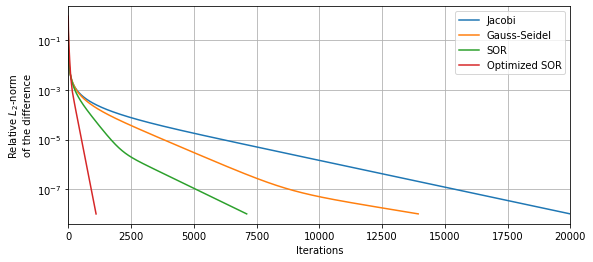

In [42]:
pyplot.figure(figsize=(9.0, 4.0))
pyplot.xlabel('Iterations')
pyplot.ylabel('Relative $L_2$-norm\nof the difference')
pyplot.grid()
pyplot.semilogy(conv_jacobi, label='Jacobi')
pyplot.semilogy(conv_gs, label='Gauss-Seidel')
pyplot.semilogy(conv_sor, label='SOR')
pyplot.semilogy(conv_opt_sor, label='Optimized SOR')
pyplot.legend()
pyplot.xlim(0, 20000);